<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
/var/folders/x9/0jzd1tbd4hg43lq3fh1q95xw0000gn/T/ipykernel_44806/3104654936.py:11: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv('../data/train_FD001.txt', sep='\s+', header=None)


Low-variance sensors: ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']


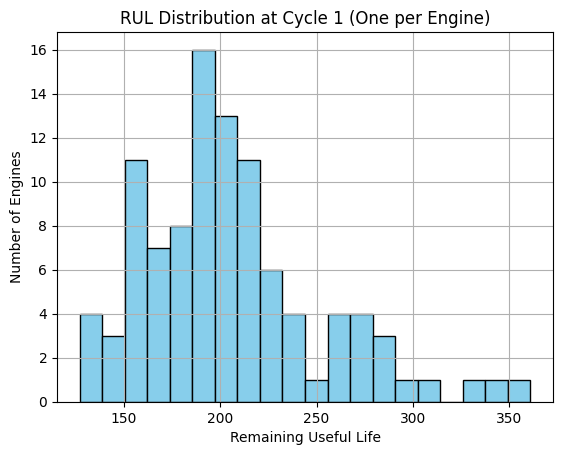

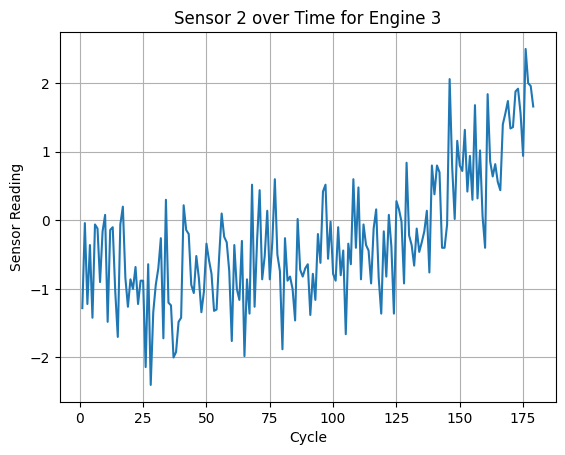

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load dataset
cols = ['unit_number', 'time_in_cycles'] + \
       [f'op_set_{i}' for i in range(1, 4)] + \
       [f'sensor_{i}' for i in range(1, 22)]

df = pd.read_csv('../data/train_FD001.txt', sep='\s+', header=None)
df = df.loc[:, df.columns != '']  # drop blank col from spacing
df.columns = cols

# Compute RUL
rul_df = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
rul_df.columns = ['unit_number', 'max_cycle']
df = df.merge(rul_df, on='unit_number', how='left')
df['RUL'] = df['max_cycle'] - df['time_in_cycles']
df.drop(columns=['max_cycle'], inplace=True)

# Drop columns with near-zero variance
sensor_cols = [col for col in df.columns if 'sensor' in col]

low_variance_sensors = []
for col in sensor_cols:
    std = df[col].std()
    if std < 0.01:
        low_variance_sensors.append(col)

print("Low-variance sensors:", low_variance_sensors)

# Drop them
df.drop(columns=low_variance_sensors, inplace=True)

# Normalize sensor + operational settings
features_to_scale = [col for col in df.columns if 'sensor' in col or 'op_set' in col]

scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# Plot RUL distribution (one row per engine)
rul_first_cycle = df[df['time_in_cycles'] == 1][['unit_number', 'RUL']]
plt.hist(rul_first_cycle['RUL'], bins=20, color='skyblue', edgecolor='black')
plt.title("RUL Distribution at Cycle 1 (One per Engine)")
plt.xlabel("Remaining Useful Life")
plt.ylabel("Number of Engines")
plt.grid(True)
plt.show()

# Preview sensor trend for one engine
sample_engine = df[df['unit_number'] == 3]
plt.plot(sample_engine['time_in_cycles'], sample_engine['sensor_2'])
plt.title("Sensor 2 over Time for Engine 3")
plt.xlabel("Cycle")
plt.ylabel("Sensor Reading")
plt.grid(True)
plt.show()

# Save the cleaned dataset
output_path = '../data/processed/cleaned_FD001.csv'
df.to_csv(output_path, index=False)
print(f"Cleaned dataset saved to {output_path}")

In [ ]:
Using the Function to generate Sliding Windows

In [1]:
from features import generate_windows
import pandas as pd
import numpy as np

df = pd.read_csv('../data/processed/cleaned_FD001.csv')
features = [col for col in df.columns if 'sensor' in col or 'op_set' in col]
X, y_rul, unit_ids, end_cycles = generate_windows(df, features, 30, 1)
print(X.shape, y_rul.shape)
np.save('../data/processed/X_windows.npy', X)
np.save('../data/processed/y_rul.npy', y_rul)
np.save('../data/processed/unit_ids.npy', unit_ids)
np.save('../data/processed/end_cycles.npy', end_cycles)

(17731, 510) (17731,)


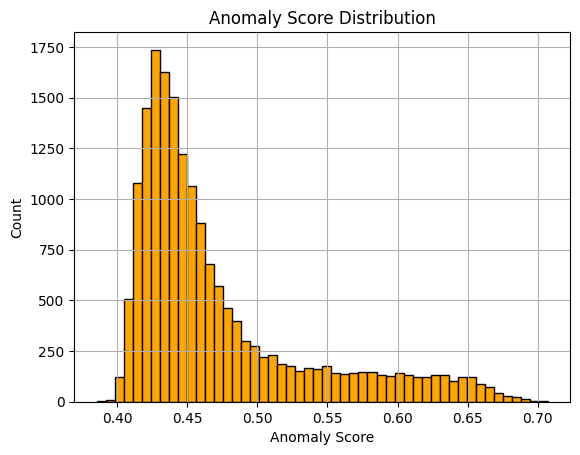

In [3]:
import numpy as np
from sklearn.ensemble import IsolationForest
import joblib
import os
import matplotlib.pyplot as plt

X = np.load('../data/processed/X_windows.npy')
y_rul = np.load('../data/processed/y_rul.npy')

# Use only high-RUL windows (assumed normal)
X_train = X[y_rul > 50]

# Train model
iso_forest = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
iso_forest.fit(X_train)

# Get anomaly scores: higher score = more anomalous
anomaly_scores = -iso_forest.score_samples(X)

os.makedirs('../models', exist_ok=True)
joblib.dump(iso_forest, '../models/isolation_forest.pkl')
np.save('../data/processed/anomaly_scores.npy', anomaly_scores)

plt.hist(anomaly_scores, bins=50, color='orange', edgecolor='black')
plt.title("Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Count")
plt.grid(True)
plt.show()



In [ ]:
Train each sliding window with Isolation Forest

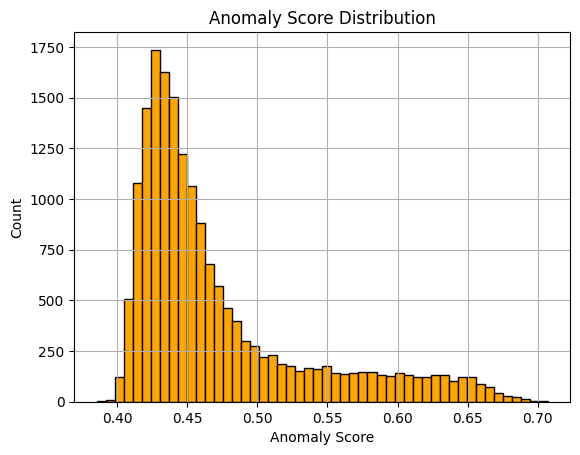

Percentage of anomaly: 3.0003947887879985%


In [11]:
    import numpy as np
    from sklearn.ensemble import IsolationForest
    import joblib
    import os
    import matplotlib.pyplot as plt
    
    X = np.load('../data/processed/X_windows.npy')
    y_rul = np.load('../data/processed/y_rul.npy')
    
    # Use only high-RUL windows (assumed normal)
    X_train = X[y_rul > 50]
    
    # Train model
    iso_forest = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
    iso_forest.fit(X_train)
    
    # Get anomaly scores: higher score = more anomalous
    anomaly_scores = -iso_forest.score_samples(X)
    
    os.makedirs('../models', exist_ok=True)
    joblib.dump(iso_forest, '../models/isolation_forest.pkl')
    np.save('../data/processed/anomaly_scores.npy', anomaly_scores)
    
    plt.hist(anomaly_scores, bins=50, color='orange', edgecolor='black')
    plt.title("Anomaly Score Distribution")
    plt.xlabel("Anomaly Score")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()
    
    thresh = np.percentile(anomaly_scores, 97)
    num_anom = np.sum(anomaly_scores >= thresh)
    pct_anom = num_anom / len(anomaly_scores) * 100
    print(f"Percentage of anomaly: {pct_anom}%")
    


In [ ]:
Inspecting anomalies

In [12]:
# Load metadata
unit_ids   = np.load('../data/processed/unit_ids.npy')
end_cycles = np.load('../data/processed/end_cycles.npy')

# Flag anomalies
mask = anomaly_scores >= thresh
anom_units   = unit_ids[mask]
anom_cycles  = end_cycles[mask]
anom_ruls     = y_rul[mask]

# Inspect first 5 anomalies
for u, c, r in zip(anom_units[:5], anom_cycles[:5], anom_ruls[:5]):
    print(f"Engine {u}, cycle {c}, RUL={r}")

Engine 1, cycle 191, RUL=1
Engine 1, cycle 192, RUL=0
Engine 2, cycle 280, RUL=7
Engine 2, cycle 283, RUL=4
Engine 2, cycle 284, RUL=3


In [13]:
# Identify anomalies that still have high RUL (>50) → likely false positives
fp_mask = mask & (y_rul > 50)
fp_units  = unit_ids[fp_mask]
fp_cycles = end_cycles[fp_mask]

print("Number of potential false positives:", fp_mask.sum())
print("Sample false positives:", list(zip(fp_units[:5], fp_cycles[:5])))


Number of potential false positives: 0
Sample false positives: []


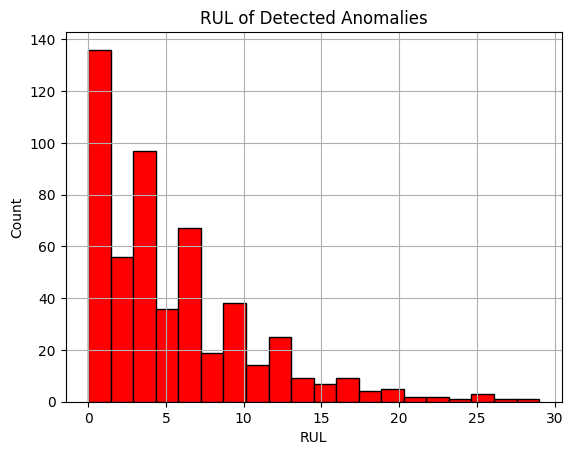

In [14]:
import matplotlib.pyplot as plt

plt.hist(anom_ruls, bins=20, color='red', edgecolor='black')
plt.title("RUL of Detected Anomalies")
plt.xlabel("RUL")
plt.ylabel("Count")
plt.grid(True)
plt.show()